**Overview**



This Python application allows users to upload PDF documents and interact with the content through natural language questions. It leverages Streamlit for the frontend, Cohere for the language model (LLM), Pinecone for vector storage, and LangChain for orchestration between the LLM and the document retrieval process. This pipeline demonstrates how to convert unstructured document data into vector embeddings, store them in Pinecone, and use an LLM to answer user queries based on the document content.

**Application Flow**
1. **Document Upload**:

- Users can upload one or more PDF documents through a file uploader interface in the Streamlit sidebar.
- Once documents are uploaded, they are processed (text extraction and chunking), and embeddings are generated using the get_embeddings function.

2. **Question Answering**:

- After document processing, the user can ask questions about the document content via a text input field.
- The user's question is converted into an embedding and used to retrieve relevant chunks from Pinecone. These chunks are passed to the LLM (Cohere), which generates a response.
- The generated response is displayed in the chat interface, alongside previous interactions, maintaining a smooth conversational flow.

**Pipeline Walkthrough** 

1. **Data Loading**:

- PDFs are uploaded by the user.
- Text is extracted using PdfReader and chunked into smaller parts for efficient embedding and retrieval.

2. **Embedding and Vector Storage**:

- The text chunks are converted into embeddings using the HuggingFaceEmbeddings model.
- The embeddings are stored in Pinecone. If the index is new, it is created dynamically; otherwise, the existing index is used.

3. **Question Answering**:

- Users submit queries about the document content through the chat interface.
- The system retrieves relevant text chunks from Pinecone using similarity search and generates responses using Cohere’s LLM, which integrates the retrieved information into a coherent answer.

4. **Memory and Context**:

- Conversation history is managed using the ConversationBufferMemory, enabling the system to maintain context across multiple questions within a session.

**Key Functions**
- **get_doc_text(documents)**: Extracts text from uploaded PDF documents.
- **get_text_chunks(text)**: Splits the extracted text into manageable chunks for embedding.
- **get_embeddings(text_chunks)**: Converts text chunks into embeddings and upserts them into a Pinecone index.
- **conversation_chain(docsearch)**: Sets up the conversational retrieval chain using the Cohere LLM and Pinecone for document retrieval.
- **handle_userinput(user_question)**: Handles user queries, retrieves relevant document chunks, and generates a response using the conversational chain.

In [1]:
%%writefile app.py

import os
import sys
import streamlit as st

from dotenv import load_dotenv
load_dotenv()

from PyPDF2 import PdfReader
from pinecone import Pinecone
from pinecone import Pinecone, ServerlessSpec
import langchain
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.chains import RetrievalQA, ConversationalRetrievalChain, create_retrieval_chain
from langchain_cohere import ChatCohere
from langchain.memory import ConversationBufferMemory
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate


from htmltemplates import  css, bot_template, user_template


def get_doc_text(documents):
    text = ''
    for doc in documents:
        doc_reader = PdfReader(doc)
        for page in doc_reader.pages:
            text+=page.extract_text()
    return text


def get_text_chunks(text):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size =800,
        chunk_overlap = 150,
        separators = [',',' ','\n'],
        length_function = len
    )
    
    chunks = text_splitter.split_text(text)
    return chunks

def get_embeddings(text_chunks):
    embedding_model =  HuggingFaceEmbeddings(model_name = "sentence-transformers/all-MiniLM-L6-v2")
    pc = Pinecone(
        api_key=os.environ.get("PINECONE_API_KEY")
    )

    # Define the index name
    index_name = 'sampleset1'
    # f indexname not found create it otherwise utilize the present one
    if not pc.has_index(index_name):
        pc.create_index(
            name=index_name,
            dimension=384,
            metric='cosine',
            spec=ServerlessSpec(
                cloud='aws',
                region='us-east-1'
            )
        )
    vector_store = PineconeVectorStore(index=index_name, embedding=embedding_model)
    # Embed each chunk and upsert the embeddings into your Pinecone index.
    docsearch = PineconeVectorStore.from_texts(
    texts=text_chunks,
    index_name = index_name,
    embedding=embedding_model
        )
    return docsearch
    
def conversation_chain(docsearch):
    #Creating the retriever
    retriever=docsearch.as_retriever()
    #Creteing the LLM of Cohere

    COHERE_API_KEY = os.environ["COHERE_API_KEY"] 
    llm = ChatCohere(model="command-r-plus")
    
    # Initialize a LangChain object for chatting with the LLM with knowledge from Pinecone. 
    memory = ConversationBufferMemory(memory_key = 'chat_history', return_messages = True)
    conversation_chain = ConversationalRetrievalChain.from_llm(
        llm = llm,
        retriever = retriever,
        memory = memory
    )
    return conversation_chain


# Function to handle user input
def handle_userinput(user_question):
    response = st.session_state.conversation({'question': user_question})
    st.session_state.chat_history = response['chat_history']

    for i, message in enumerate(st.session_state.chat_history):
        if i % 2 == 0:
            st.write(user_template.replace(
                "{{MSG}}", message.content), unsafe_allow_html=True)
        else:
            st.write(bot_template.replace(
                "{{MSG}}", message.content), unsafe_allow_html=True)

# Main application function
def main():
    st.set_page_config(page_title='Chat with documents', page_icon=':books:')
    
    st.write(css, unsafe_allow_html=True)
    if "conversation" not in st.session_state:
        st.session_state.conversation = None
    if "chat_history" not in st.session_state:
        st.session_state.chat_history = None
    
    
    st.header('Chat with documents :books:')
    
    user_question = st.text_input("Ask Questions About Document:")
    if user_question:
        handle_userinput(user_question)  
    
    # Sidebar for document upload
    with st.sidebar:
        st.subheader('Documents')
        documents = st.file_uploader("Upload Documents", accept_multiple_files=True)
        if st.button('Process'):
            with st.spinner('Processing...'):
                # Extract text from uploaded documents
                raw_text = get_doc_text(documents)
                
                # Create text chunks
                text_chunks = get_text_chunks(raw_text)
                
                # Create embeddings and a vector store
                embedded_docs = get_embeddings(text_chunks)
                
                # Store conversation chain in session state
                st.session_state.conversation = conversation_chain(embedded_docs)
    
         
    
    
if __name__ == '__main__':
    main()


Writing app.py


In [2]:
!streamlit run app.py

^C


**Sample Outputs**

- Document used - Reference for choosing right data visualization.pdf 

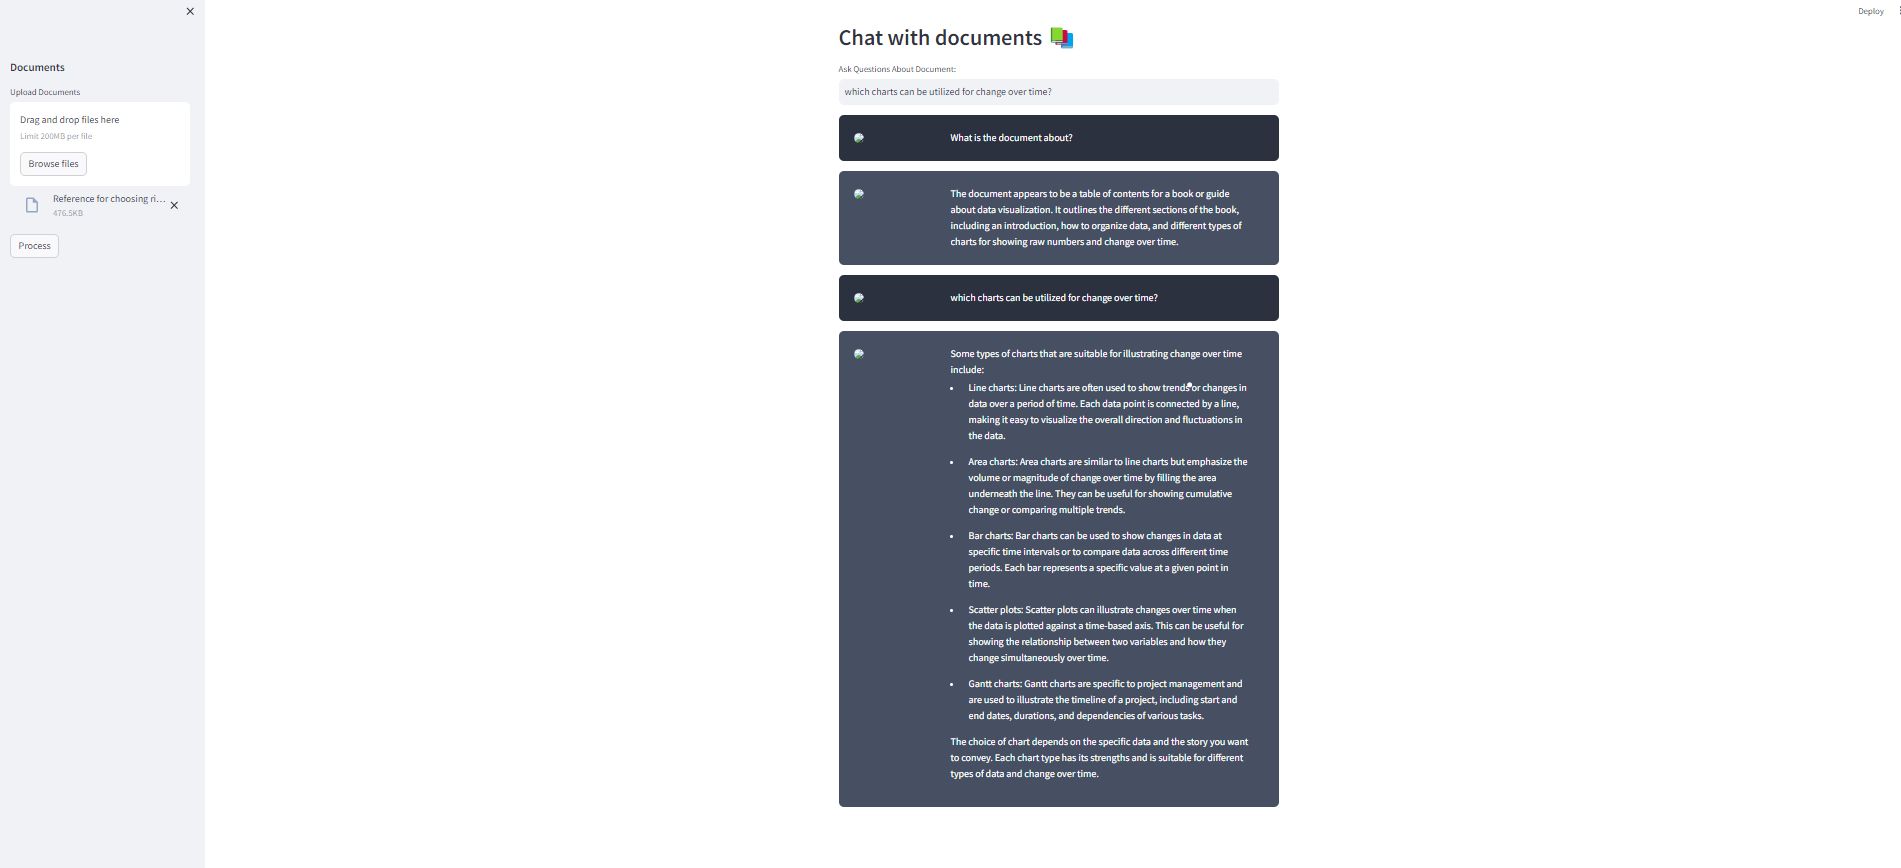